<h1 style="color: blue"> TPS August </h1>




## [Contents](#h1)
* <p style="color:violet"> Data and EDA</p>
* <p style="color:violet"> Plotting Functions</p>
* <p style="color:violet"> Running Base Model</p>
* <p style="color:violet"> Engineer Features</p>
* <p style="color:violet">Optuna and XGB </p>

## Data and EDA

In [2]:
import pandas as pd
import os
import numpy as np

def load_data(path):
    """
    Takes path oof csv file
    and returns dataframe object.
    """
    try:
        data = pd.read_csv(path)
        return data
    except:
        print("Not a valid file")

class Dataframe(pd.DataFrame):
    
    def __init__(self, dataframe):
        super().__init__(dataframe)

       
    def feature_columns(self, drop_col=list()):
        """
        Extract feature columns from dataframe
        with reference to drop_col
        """
        return [col for col in self.drop(drop_col, axis=1).columns]
    
    def int_feature_dtypes(self):
        """
        Get integer dtypes
        pandas has a method already for this
        df[df.dtypes==dtype]
        """
        
        return list(filter(lambda x: True if x[1]==np.dtype('int64') else False, zip(self.columns,self.dtypes)))
    
    def pos_features(self):
        """
        Get positive features
        from the data.
        """
        return list(filter(lambda x: all(df_train[x]>0), df_train.columns[:-1]))
    

In [3]:
#path
path = "/kaggle/input/tabular-playground-series-aug-2021/"

#training and test files location
csv_files = [os.path.join(path, x) for x in ["train.csv", "test.csv"]]

#tuple object of csv files
tables = (load_data(csv) for csv in csv_files)

In [4]:
# Create Class instance 
df_train, df_test = tables
df_train = Dataframe(df_train)
df_test = Dataframe(df_test)
df_train.columns

Index(['id', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       ...
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'loss'],
      dtype='object', length=102)

In [5]:
#check shapes 
print(df_train.shape, df_test.shape)

#get all names of feature columns
features = df_train.feature_columns(drop_col=['id','loss'])

(250000, 102) (150000, 101)


In [6]:
#Total number of features

df_train.drop(["id"], axis=1, inplace=True)
print(len(features))

#Purely Integer Features

integer_features = df_train.int_feature_dtypes()
print(*integer_features,sep='\n')

100
('f1', dtype('int64'))
('f16', dtype('int64'))
('f27', dtype('int64'))
('f55', dtype('int64'))
('f86', dtype('int64'))
('loss', dtype('int64'))


In [7]:
#Strictly Positive Features

pos_features = df_train.pos_features()
print(pos_features)

['f9', 'f12', 'f23', 'f26', 'f29', 'f30', 'f34', 'f46', 'f53', 'f57', 'f58', 'f64', 'f78', 'f79', 'f84', 'f93', 'f97']


## Plotting Functions

In [8]:
#visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#plots in rows and cols
def plot_dics():
    
    sns_distributions={'kde':sns.kdeplot,'histplot':sns.histplot}
    return sns_distributions

def skew_plot(skew_values):
    """
    Plots skew from a series of skew values.
    """
    skew_values_positive = skew_values[skew_values>0]
    skew_values_negative = skew_values[skew_values<0]
    skew_values_zero = skew_values[skew_values==0]
    row_size = len(skew_values)
    index_list = dict(map(lambda x: (x[1], x[0]),enumerate(skew_values.index)))
    
    #plot values positive values
    plt.scatter(x=[index_list[key] for key in skew_values_positive.index], y=skew_values_positive,color='blue')
    plt.plot(range(row_size), np.ones(row_size), color ='blue')
    
    #plot negative values
    plt.scatter(x=[index_list[key] for key in skew_values_negative.index], y=skew_values_negative,color='red')
    plt.plot(range(row_size), -1*np.ones(row_size), color ='red')
    
    plt.scatter(x=[index_list[key] for key in skew_values_zero.index], y=skew_values_zero,color='green')
    plt.plot(range(row_size), np.zeros(row_size), color ='green')
    plt.xticks(np.arange(0, len(skew_values), 3), skew_values.index[::3]); #set ticks
    plt.title("Scatter Plot of Skew values for each column")
    plt.grid()

def legend(sns_plot,value):
    sns_plot.legend(f"skew:{value:.2f}", loc="best")
    
def dist_plots(sns_plot, dataframe, features, figsize=(6, 6), rows=1, cols=1,sharex=False, colors=False):
    """
    Plots histplots and kernel density estimators using seaborn
    """
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize,sharex=sharex)
    feature_index = 0
    if colors:
        colors = sns.color_palette(n_colors=(rows*cols))
    else :
        colors = [None]*(rows*cols)
    try:
        if rows*cols >= len(features):
            if rows > 1 and cols > 1:
                for i in range(rows):
                    for j in range(cols):
                        if feature_index <= len(features)-1:
                            g = sns_plot(dataframe[features[feature_index]], ax=ax[i][j], color=colors[feature_index])
                            feature_index+=1
                        else:
                            break          
            elif rows > 1 and cols == 1:
                 for i in range(rows):
                        if feature_index <= len(features)-1:
                            g = sns_plot(dataframe[features[feature_index]], ax=ax[i], color=colors[feature_index])
                            feature_index += 1
                        else:
                            break  
            elif rows and cols:
                g = sns_plot(dataframe[features[feature_index]], ax=ax, color=colors[feature_index])
                
        else:
            raise ValueError()
    except ValueError:
        raise ValueError("rows*cols should be greater than or equal to the number of features")
        

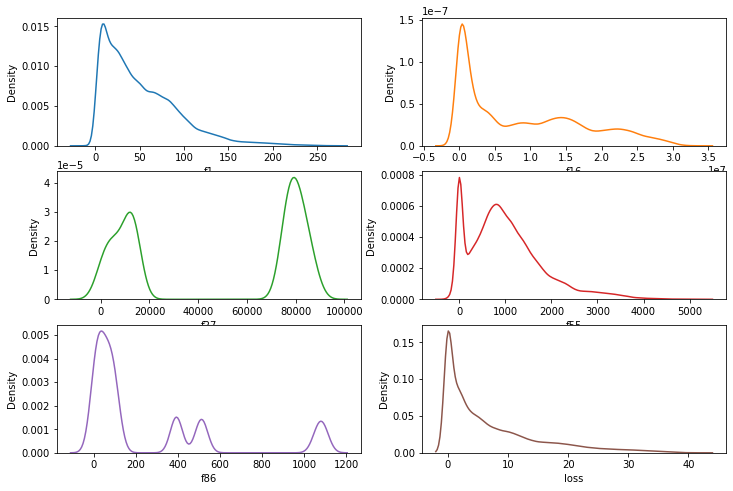

In [10]:
sns_hist = plot_dics()['kde']
dist_plots(sns_hist, df_train, list(map(lambda x:x[0], integer_features)), figsize=(12, 8),rows=3, cols=2, colors=True)

The loss ditribution of loss is asymmetric and so are many features we will normalize them.

### Skew Plots

In [11]:
#get all skewed values
skew_values=df_train.skew()
print("=============")

#print columns with skew values greater than 1
print(*skew_values[skew_values>1].index, sep=" ")

#print columns with skew values less than 1
print("=============")
print(*skew_values[skew_values<-1].index, sep=" ")

f1 f4 f5 f6 f9 f13 f15 f21 f22 f23 f28 f30 f33 f35 f36 f41 f44 f45 f49 f50 f52 f54 f55 f56 f57 f59 f64 f75 f77 f79 f81 f83 f86 f87 f89 f90 f91 f93 f99 loss
f37 f39 f51 f85


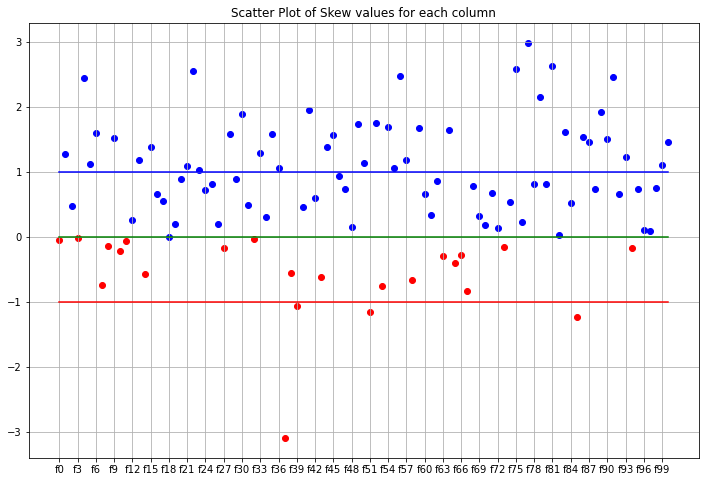

In [12]:
plt.figure(figsize=(12, 8))
skew_plot(skew_values)

## Regression

In [13]:
from sklearn.model_selection import train_test_split

#Shape before the split
print(df_train.shape)

# Split the set in train, cross-validation, test set
X_train,X_,y_train, y_ = train_test_split(df_train.drop(["loss"],axis=1),df_train["loss"], test_size=0.3, shuffle=True, random_state=23)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_, test_size=1/2,shuffle=True, random_state=100)

#Trainging set
print(f"Training Size: {X_train.shape}")

#cross-validation set
print(f"CV Size: {X_cv.shape}")

#test test
print(f"Test Size: {X_test.shape}")

(250000, 101)
Training Size: (175000, 100)
CV Size: (37500, 100)
Test Size: (37500, 100)


### Scaling Data

In [14]:
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, PowerTransformer

# all transformers
def transform_data(df, transformer_name='standardscaler'):
    transformer_dict = {"standardscaler":StandardScaler,
                        "normalizer":Normalizer,
                        "gaussian":PowerTransformer,
                        "robustscaler": RobustScaler}
    return transformer_dict[transformer_name]().fit_transform(df)

temp_list = []
for df in [X_train, X_cv, X_test]:
    temp_list.append(transform_data(transform_data(df, transformer_name="standardscaler"), transformer_name="normalizer"))

In [15]:
#Unpack the values
X_train_gaussian,X_cv_gaussian, X_test_gaussian = temp_list

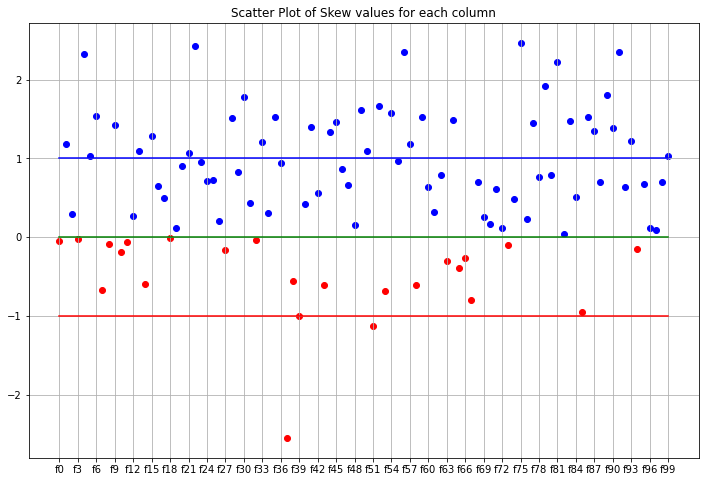

In [16]:
df_train_gaussian = pd.DataFrame(X_train_gaussian, columns=df_train.columns[:-1])
df_cv_gaussian = pd.DataFrame(X_cv_gaussian, columns=df_train.columns[:-1])
df_test_gaussian = pd.DataFrame(X_test_gaussian, columns=df_train.columns[:-1])

#After transform skewed values
print("=============")
plt.figure(figsize=(12, 8))
skew_values_gaussian = df_train_gaussian.skew()
skew_plot(skew_values_gaussian)

### Plots after scaling

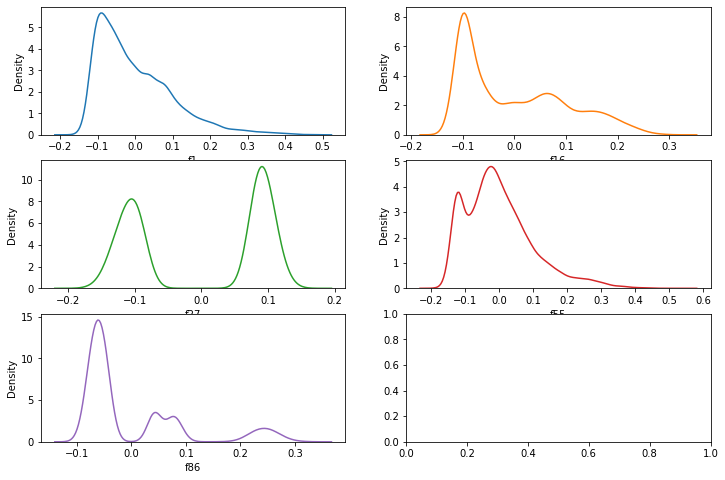

In [17]:
dist_plots(sns_hist, df_test_gaussian, list(map(lambda x:x[0], integer_features[:-1])), figsize=(12, 8),rows=3, cols=2, colors=True)

## Running Base Model

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

#classical
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression, Lasso

#Experimental feature in scikit-learn
from sklearn.experimental import enable_hist_gradient_boosting

#Ensemble regressors
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
import xgboost as xgb

model_dict = {"ridge":Ridge, "bayesridge":BayesianRidge,
                  "linearreg":LinearRegression, "lasso":Lasso}

#Fitting without any parameters adjustment
def fit_model(X, y, model="linearreg"):
    model = model_dict[model]()
    model.fit(X, y)
    return model

#predict function
def predict_y(X, model):
    y_pred = model.predict(X)
    return y_pred
  
# root mean square error  
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Coefficient Histogram and line plots
def coefficient_plot(model_name,models,ax, color):
    for model in models:
        ax[0].plot(model.coef_, linestyle='-', color=color[models.index(model)])
    ax[0].legend(model_name)
    for model in models:
        ax[1].bar([list(model.coef_).index(val) for val in list(model.coef_)], model.coef_, color=color[models.index(model)],label=features)
    ax[1].legend(model_name)

In [19]:
def run_base_model(X_train, y_train, X_test, y_test):
    """
    Run base models and select the best model
    """
    error_train = None
    error_rmse = None
    base_model = None
    for key in model_dict.keys():
        model_error = 0
        _=20
        model_name = model_dict[key].__name__
        print("="*_+f"{model_name}"+"="*(abs(len(model_name)-_)), end="\n")
        model = fit_model(X_train, y_train, model=key)
        
        model_error = rmse(predict_y(X_train, model), y_train)   
        if error_train is None:
            error_train = model_error
        elif error_train > model_error:
            base_model = model
            error_train = model_error
            print(f"Low error found {model_error}--{model_name}")
        print(f"Train Root Mean Squared Error: {model_error}", end="\n")
        print("\n")
    
    print("Base Model with low error on training set "+str(base_model).replace("()",""))
    print("\n")
    print("Base Model Prediction on Cross Validation Set")
    y_pred_cv = predict_y(X_test, base_model)
    error_rmse = rmse(y_pred_cv, y_test)
    print(f"Prediction Root Mean Squared Error: {error_rmse}")
    
    return base_model, error_train
base_model, error_train = run_base_model(X_train_gaussian, y_train, X_cv_gaussian, y_cv)
error_train

====================Ridge===============
Train Root Mean Squared Error: 7.91988460089714


====================BayesianRidge=======
Train Root Mean Squared Error: 7.919994218492809


====================LinearRegression====
Low error found 7.91988458705902--LinearRegression
Train Root Mean Squared Error: 7.91988458705902


====================Lasso===============
Train Root Mean Squared Error: 7.966735130127021


Base Model with low error on training set LinearRegression


Base Model Prediction on Cross Validation Set
Prediction Root Mean Squared Error: 7.802892202591257


7.91988458705902

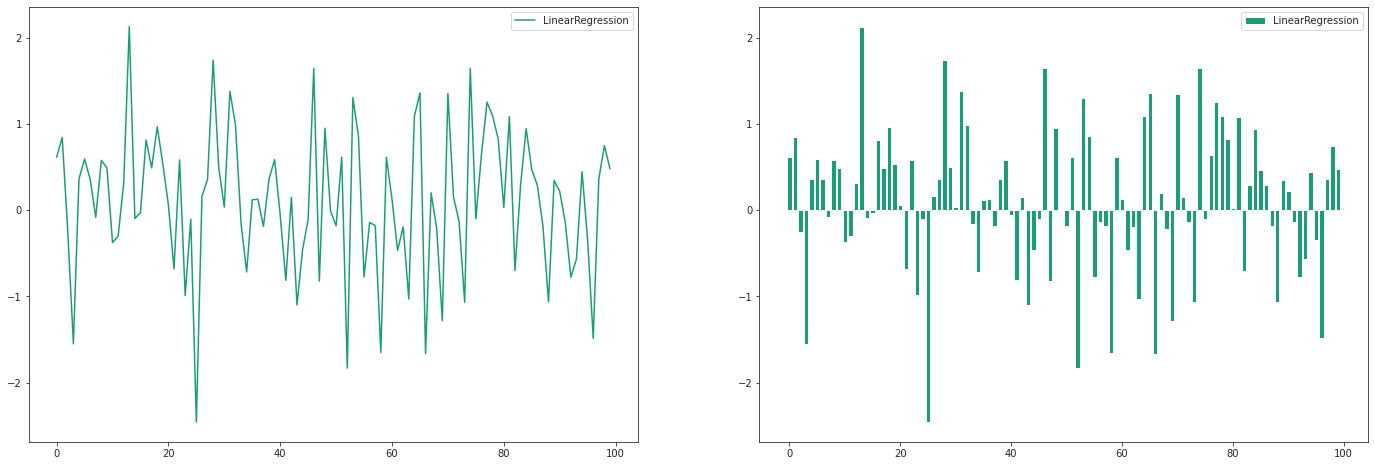

In [20]:
import matplotlib as mpl
sns.set_style("ticks")
fig_coef, ax_coef = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
colormap = mpl.cm.Dark2.colors
model_names = [str(base_model).replace("()","")]
coefficient_plot(model_names, [base_model], ax_coef, colormap)

['f30', 'f80', 'f49', 'f15']


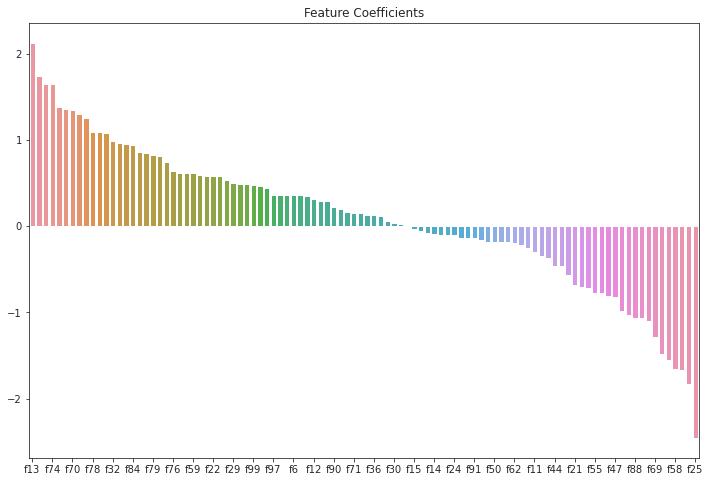

In [21]:
a = list(zip(features,base_model.coef_))
fig_bar, ax_bar = plt.subplots( figsize=(12, 8))
a.sort(key=lambda x: x[1])
a=dict(a[::-1])
sns.barplot(y=list(a.values()), x=list(a.keys()), ax=ax_bar)
ax_bar.set_title("Feature Coefficients");
ax_bar.set_xticks(range(0, len(a.keys()), 3))
ax_bar.set_xticklabels(list(a.keys())[::3]);
drop_features = list(filter(lambda x: True if -0.05<=a[x]<=0.05 else False, a.keys()))
print(drop_features)

In [22]:

#Predicting on actual test set
real_test = transform_data(transform_data(df_test.drop(["id"],axis=1), transformer_name="standardscaler"),transformer_name="normalizer")
real_test.shape

(150000, 100)

In [23]:
def submission(y_pred, col, file_name):
    """
    Submission Function 
    with filename
    """
    data = pd.DataFrame({"id":col, "loss":y_pred})
    sub_files = []
    for dirname,_, filenames in os.walk("./"):
            for file in filenames:
                if file.endswith(".csv"):
                    sub_files.append(file)
    if len(sub_files)>0:
        new_n = str(int(sub_files[-1].split(".")[0][-1])+1)
    else:
        new_n=1
    data.to_csv(f"./{file_name}{new_n}.csv", index=False)            

In [24]:
#using LR
y_pred_real = base_model.predict(real_test)
submission(y_pred_real, df_test["id"], "bayes")

Lowest error on 25% of data: 7.94038 using bayesridge using standardscaler with no tuning
Highest error on 25% of data: 7.9433 using robustscaler and normazlier

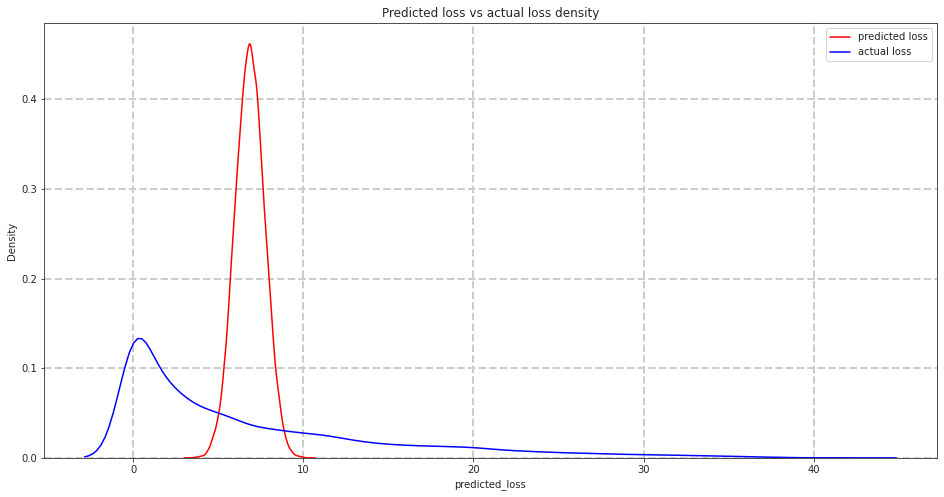

In [25]:
# dist_plots(sns_hist, , ["predicted_loss","test_loss"], rows=2, cols=1, colors=True)
# sns_plot(dataframe[features[feature_index]], ax=ax[i][j], color=colors[feature_index])
fig,ax = plt.subplots(figsize=(16, 8))
g1 = sns.kdeplot( "predicted_loss", data = pd.DataFrame({"predicted_loss":base_model.predict(X_cv_gaussian), "test_loss":y_cv}), color='red', ax = ax)
g2 = sns.kdeplot("test_loss", data=pd.DataFrame({"predicted_loss":base_model.predict(X_cv_gaussian), "test_loss":y_cv}), color='blue', ax=ax)

ax.grid(linestyle='--', linewidth=2)
ax.legend(["predicted loss", "actual loss"]);
ax.set_title("Predicted loss vs actual loss density");
              

# Feature Engineering

In [26]:
def square_root(col_list, data):
    
    #add square root columns
    new_data = data.copy()
    for col in col_list:
        new_data["sqrt_"+col]= np.sqrt(data[col])
    return new_data

def square(col_list, data):
    
    #add squares for col
    new_data = data.copy()
    for col in col_list:
        new_data["sqr"+col]= (data[col])*(data[col])
    return new_data

def reciprocals(col_list, data):
    #add reciprocals for col_list
    new_data = data.copy()
    for col in col_list:
        new_data["rec"+col]= 1/(abs(data[col])+1)                      
    return new_data

def product_col(data):
    #all product gives one column
    new_data = data.copy()
    temp = data[data.columns[0]]
    for col in data.columns:
        temp *= data[col]
    new_data["all_product"] = temp
    return new_data
    

def update_sets(data_list):
    temp_list = []
    for df in data_list:
        temp_list.append(square(df.columns, data=df))
    return temp_list

In [27]:
X_train_f1 = reciprocals(features, data=square(features, data=X_train))
X_cv_f1 = reciprocals(features, data= square(features, data=X_cv))
X_test_f1 = reciprocals(features, data=square(features, data=X_test))
temp_list1 = []
for df in [X_train_f1, X_cv_f1, X_test_f1]:
    temp_list1.append(transform_data(transform_data(df, transformer_name="standardscaler"), transformer_name="normalizer"))

In [28]:
X_train_sqrt_gaussian, X_cv_sqrt_gaussian, X_test_sqrt_gaussian = temp_list1

In [29]:
base_model_v1, error_v1 = run_base_model(X_train_sqrt_gaussian, y_train, X_cv_sqrt_gaussian, y_cv)

====================Ridge===============
Train Root Mean Squared Error: 7.893032514705105


====================BayesianRidge=======
Train Root Mean Squared Error: 7.896841491089084


====================LinearRegression====
Low error found 7.891628597357512--LinearRegression
Train Root Mean Squared Error: 7.891628597357512


====================Lasso===============
Train Root Mean Squared Error: 7.966735130127021


Base Model with low error on training set LinearRegression


Base Model Prediction on Cross Validation Set
Prediction Root Mean Squared Error: 7.783425348688182


Observe that the same linear regression gives a error of 7.783425 on validation set with added features

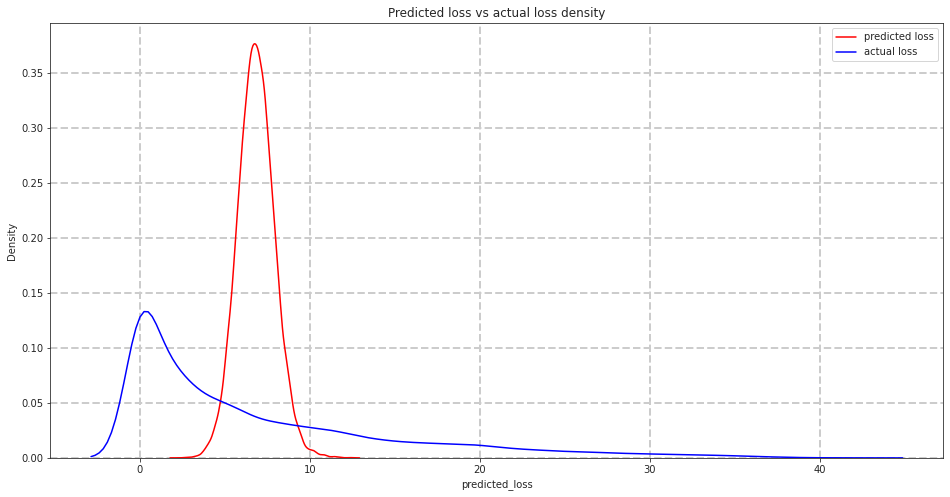

In [30]:
fig_v1,ax_v1 = plt.subplots(figsize=(16, 8))
g1 = sns.kdeplot( "predicted_loss", data = pd.DataFrame({"predicted_loss":base_model_v1.predict(X_cv_sqrt_gaussian), "cv_loss":y_cv}),
                 color='red', ax = ax_v1)
g2 = sns.kdeplot("cv_loss", data=pd.DataFrame({"predicted_loss":base_model_v1.predict(X_cv_sqrt_gaussian), "cv_loss":y_cv}),
                 color='blue', ax=ax_v1)

ax_v1.grid(linestyle='--', linewidth=2)
ax_v1.legend(["predicted loss", "actual loss"]);
ax_v1.set_title("Predicted loss vs actual loss density");
              

In [31]:
real_test_v1 = reciprocals(features, data=square(features, data=df_test.drop(["id"],axis=1)))
real_test_v1 = transform_data(transform_data(real_test_v1, transformer_name="standardscaler"),transformer_name="normalizer")
real_test_v1.shape

(150000, 300)

In [32]:
#using linear regression with squared features
y_pred_real = base_model_v1.predict(real_test_v1)
submission(y_pred_real, df_test["id"], "submission")

NICE! Adding Square and reciprocal terms Terms brought the error down by 1.36% that is 92439 previous error was 94038.

## Optuna and XGB

In [35]:
#Method was taken from a kaggle notebook from last feb i don't rememeber the link
def objective(trial):
    
    train_x, test_x, train_y, test_y = X_train_sqrt_gaussian, X_cv_sqrt_gaussian, y_train, y_cv
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,90, 100, 120]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

Best Parameters Obtained

{"lambda": 0.04001717971729262, "alpha": 0.001537777755465056, "colsample_bytree": 0.5, "subsample": 0.7, "learning_rate": 0.009, "max_depth": 9, "random_state": 48, "min_child_weight": 282}

In [36]:
# ! pip install optuna
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-08-28 18:48:48,670] A new study created in memory with name: no-name-69adf27b-cab1-423e-8587-c059d7d3108e
[I 2021-08-28 18:49:20,461] Trial 0 finished with value: 7.773182705282253 and parameters: {'lambda': 2.1377513501410985, 'alpha': 0.0016283082384259038, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 90, 'min_child_weight': 203}. Best is trial 0 with value: 7.773182705282253.
[I 2021-08-28 18:49:49,644] Trial 1 finished with value: 7.774514731581736 and parameters: {'lambda': 1.345371639624416, 'alpha': 0.2969731856748529, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 120, 'min_child_weight': 124}. Best is trial 0 with value: 7.773182705282253.
[I 2021-08-28 18:50:23,348] Trial 2 finished with value: 7.759831239000829 and parameters: {'lambda': 0.030918106546656346, 'alpha': 0.042257649507828794, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_

Number of finished trials: 50
Best trial: {'lambda': 0.09618717518554759, 'alpha': 0.0028036438384580684, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 120, 'min_child_weight': 161}


7.8306 on CV with hundred estimators

In [37]:
import json
with open("./best_param_120RS.json", "w") as f:
    json.dump(study.best_trial.params, f)
study.best_trial.params

{'lambda': 0.09618717518554759,
 'alpha': 0.0028036438384580684,
 'colsample_bytree': 0.5,
 'subsample': 0.7,
 'learning_rate': 0.008,
 'max_depth': 7,
 'random_state': 120,
 'min_child_weight': 161}

In [39]:
from sklearn.model_selection import RepeatedKFold, KFold

hp = study.best_trial.params

hp["tree_method"]="gpu_hist"
hp["verbosity"] = 0
hp["objective"] = "reg:squarederror"
hp["n_estimators"] = 4000

train = pd.concat([pd.DataFrame(X_train_sqrt_gaussian, columns=X_train_f1.columns,index=X_train_f1.index),
                   pd.DataFrame(X_cv_sqrt_gaussian, columns=X_cv_f1.columns,index=X_cv_f1.index)])
                   
df_y_train = pd.concat([y_train,y_cv])
test = pd.DataFrame(real_test_v1, columns=X_train_f1.columns)

y_preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse_error=[]  # list contains rmse for each fold
n=0
for trn_idx, test_idx in kf.split(train, df_y_train):
    
    X_tr,X_val=train.iloc[trn_idx],train.iloc[test_idx]
    y_tr,y_val=df_y_train.iloc[trn_idx],df_y_train.iloc[test_idx]
    
    model_xgb = xgb.XGBRegressor(**hp)
    model_xgb.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    
    y_preds+=model_xgb.predict(test)/kf.n_splits
    
    rmse_error.append(mean_squared_error(y_val, model_xgb.predict(X_val), squared=False))
    
    print("Fold", n+1,rmse_error[n])
    
    n+=1

Fold 1 7.855653165727012
Fold 2 7.894848139707423
Fold 3 7.845109563929731
Fold 4 7.844316069640973
Fold 5 7.847161080415499


In [40]:
submission(y_preds, df_test["id"], "1_submission")

In [41]:
optuna.visualization.plot_optimization_history(study)

In [42]:
optuna.visualization.plot_parallel_coordinate(study)

In [43]:
model_xgb.save_model("./xgb_model_Rs120")

In [44]:
optuna.importance.get_param_importances(study)

OrderedDict([('min_child_weight', 0.5174936810563666),
             ('learning_rate', 0.387343083770181),
             ('subsample', 0.047923545105682204),
             ('max_depth', 0.02009515296442594),
             ('random_state', 0.010161738372970526),
             ('colsample_bytree', 0.009205022243522433),
             ('alpha', 0.005676749065659648),
             ('lambda', 0.0021010274211917105)])